In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv('../dataset/GOOG-year.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2016-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2016-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2016-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2016-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800


In [3]:
def buy_stock(
    real_movement,
    signal,
    initial_money=10000,
    max_buy=1,
    max_sell=1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0
    global last_buy_skipped
    last_buy_skipped = True  # Flag to track if the last buy was skipped

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares >= 1:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            states_buy.append(i)
            last_buy_skipped = True  # Reset the flag
        return initial_money, current_inventory,last_buy_skipped

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1.0:
            initial_money, current_inventory,last_buy_skipped = buy(i, initial_money, current_inventory)
            states_buy.append(0)
        elif state == -1.0:
            # Sell logic

            if current_inventory != 0:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                
                
            states_sell.append(i)
            last_buy_skipped = False  # Reset the flag

    # Skip the last buy if it was made
    if last_buy_skipped:
        states_buy.pop()
        invest = ((initial_money - starting_money + real_movement[next(filter(lambda x: x != 0, states_buy[::-1]))]) / starting_money) * 100
        total_gains = initial_money - starting_money + real_movement[next(filter(lambda x: x != 0, states_buy[::-1]))]

    else:
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
    return total_gains


In [4]:
def driver(n):
    gains = []
    short_window = int(0.025 * len(df))
    for i in range(1,n+1):
        long_window = int(0.05 * len(df))*i
        signals = pd.DataFrame(index=df.index)
        signals['signal'] = 0.0

        signals['short_ma'] = df['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
        signals['long_ma'] = df['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

        signals['signal'][short_window:] = np.where(signals['short_ma'][short_window:] > signals['long_ma'][short_window:], 1.0, 0.0)

        signals['positions'] = signals['signal'].diff()
        gain = buy_stock(df.Close, signals['positions'])
        gains.append([long_window,gain])
    return gains

In [5]:
total_gains = driver(8)

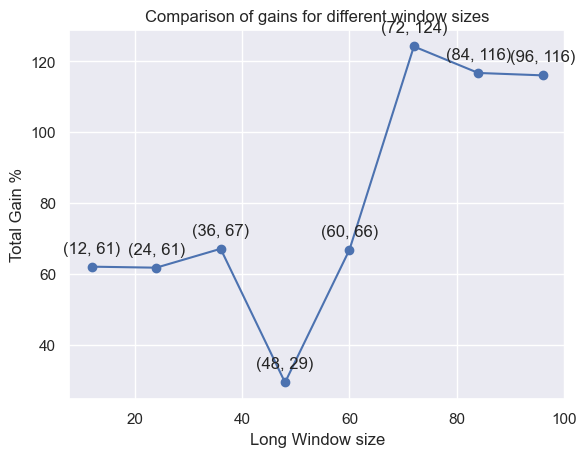

In [6]:
x = [point[0] for point in total_gains]  
y = [point[1] for point in total_gains]  
plt.plot(x, y, marker='o', linestyle='-', color='b')  # Plot the graph
for i, j in total_gains:
    plt.annotate(f'({i}, {int(j)})', (i,j), textcoords="offset points", xytext=(0,10), ha='center')
    
plt.xlabel('Long Window size')
plt.ylabel('Total Gain %')
plt.title('Comparison of gains for different window sizes')
plt.show()